In [1]:
import os
import sys
sys.path.append("..")
import numpy as np
from py_helpers.general_helpers import *

# Define the paths to the results
labs = True
if labs:
    results_path = "/media/hsa22/Expansion/WBM/results"
else:
    results_path = "D:\\WBM\\results"

## **Load the Data**

In [2]:
# Function to return a dictionary of the files organized
def organize_files(txt_files, csv_files, name="model"):

    # Dictionary to store the files
    organized_files = {}

    # Loop through the files and add them to the dictionary
    for file in txt_files:
        # Depending on name, add it to the dictionary
        if name in file:
            # Get whether it's symmetric or not
            symmetric = file.split(os.sep)[-3]
            # Define the corresponding csv as the path up until -1
            corresponding_csv = os.path.join((os.sep).join(file.split(os.sep)[:-1]), "sim_FC.csv")
            # If the csv exists, add it to the dictionary
            if corresponding_csv in csv_files:
                data_dict = {
                    "txt_path": file,
                    "csv_path": corresponding_csv,
                    "correlation": np.loadtxt(file),
                    "sim_FC": np.genfromtxt(corresponding_csv, delimiter=",")
                }
                
                # Append the data dictionary to the organized_files under symmetric key
                if symmetric in organized_files:
                    organized_files[symmetric].append(data_dict)
                else:
                    organized_files[symmetric] = [data_dict]

    # Return the dictionary
    return organized_files

In [3]:
# Grab all the txt and csv files for the correlation
txt_files = glob_files(results_path, "txt")
csv_files = glob_files(results_path, "csv")

# Assert that the number of txt and csv files are the same
assert len(txt_files) == len(csv_files), "Number of txt and csv files are not the same!"

# Define dictionary for model, traditional, and tracer files
model_files = organize_files(txt_files, csv_files, name="model")
trad_files = organize_files(txt_files, csv_files, name="traditional")
tracer_files = organize_files(txt_files, csv_files, name="tracer")

# Print the length of each dictionary - or the number of items for both symmetric and asymmetric
# print("Number of symmetric model files: {}".format(len(model_files["symmetric"])))
print("Number of asymmetric model files: {}".format(len(model_files["asymmetric"])))
# print("Number of symmetric traditional files: {}".format(len(trad_files["symmetric"])))
print("Number of asymmetric traditional files: {}".format(len(trad_files["asymmetric"])))
print("Number of symmetric tracer files: {}".format(len(tracer_files["symmetric"])))
print("Number of asymmetric tracer files: {}".format(len(tracer_files["asymmetric"])))

Number of asymmetric model files: 298
Number of asymmetric traditional files: 303
Number of symmetric tracer files: 272
Number of asymmetric tracer files: 302


## **Organize Data into Pandas Dataframe**

In [4]:
import pandas as pd
import re

# Function to organize data into pandas dataframe
def extract_data_and_create_df(entries):
    """Utility function to extract data and create a dataframe."""
    df_rows = []
    for entry in entries:
        # Extract the coupling and delay values using regex
        match = re.search(r"Coupling (\d+\.\d+), Delay(\d+\.\d+)", entry["txt_path"])

        if match:
            coupling, delay = float(match.group(1)), float(match.group(2))
            df_rows.append(((coupling, delay), entry["correlation"]))

    return pd.DataFrame(df_rows, columns=["(Coupling, Delay)", "Correlation"])

In [11]:
import pandas as pd
import re

# Create a dataframe for the model, traditional, and tracer
model_asym_df = extract_data_and_create_df(model_files["asymmetric"])
trad_asym_df = extract_data_and_create_df(trad_files["asymmetric"])
tracer_asym_df = extract_data_and_create_df(tracer_files["asymmetric"])

# Print the length of each dataframe
print("Number of asymmetric model dataframes: {}".format(len(model_asym_df)))
print("Number of asymmetric traditional dataframes: {}".format(len(trad_asym_df)))
print("Number of asymmetric tracer dataframes: {}".format(len(tracer_asym_df)))

# Print the maximum correlation for each dataframe
print("Max correlation for model: {}".format(model_asym_df["Correlation"].max()))
print("Max correlation for traditional: {}".format(trad_asym_df["Correlation"].max()))
print("Max correlation for tracer: {}".format(tracer_asym_df["Correlation"].max()))

Number of asymmetric model dataframes: 298
Number of asymmetric traditional dataframes: 303
Number of asymmetric tracer dataframes: 302
Max correlation for model: 0.07898053
Max correlation for traditional: 0.03760527
Max correlation for tracer: 0.08782831


## **Plot the Data**

In [6]:
import seaborn as sns

# Generate a cubehelix color palette with more contrast
color_palette = sns.cubehelix_palette(8, start=0.8, rot=-0.4, dark=0.1, light=0.9)
pinkish = color_palette[2]
purpleish = color_palette[6]
inbetween = color_palette[4]

beige_palette = sns.light_palette(color_palette[4], n_colors=10)
beige_color = beige_palette[1]
custom_colorscale = [
    [0, 'rgb'+str(pinkish)],
    [0.5, 'rgb'+str(beige_color)],
    [1, 'rgb'+str(purpleish)]
]

def gradient_stem(ax, x, y, z, bottom, color_start, color_end):
    """
    Create a stem plot with gradient color effect.
    :param ax: Axis to plot on
    :param x, y, z: Data for stems
    :param bottom: Bottom of stems
    :param colors: List of color for gradient
    """
    segments = len(z)
    for i, (xi, yi, zi) in enumerate(zip(x, y, z)):
        z_points = np.linspace(bottom, zi, segments)
        colors = [((zi - v) / (zi - bottom) * np.array(color_start) + (v - bottom) / (zi - bottom) * np.array(color_end)) for v in z_points]
        for j in range(1, segments):
            ax.plot([xi, xi], [yi, yi], [z_points[j-1], z_points[j]], color=colors[j])
            
        # Here we add the circle top at the end of each stem
        ax.scatter(xi, yi, zi, c=[tuple(color_end)], s=20)  # You can adjust `s` for size

Minimum correlation: -0.01679007
Maximum correlation: 0.07898053


/tmp/ipykernel_3091001/3740401266.py:28: RuntimeWarning: invalid value encountered in scalar divide
  colors = [((zi - v) / (zi - bottom) * np.array(color_start) + (v - bottom) / (zi - bottom) * np.array(color_end)) for v in z_points]


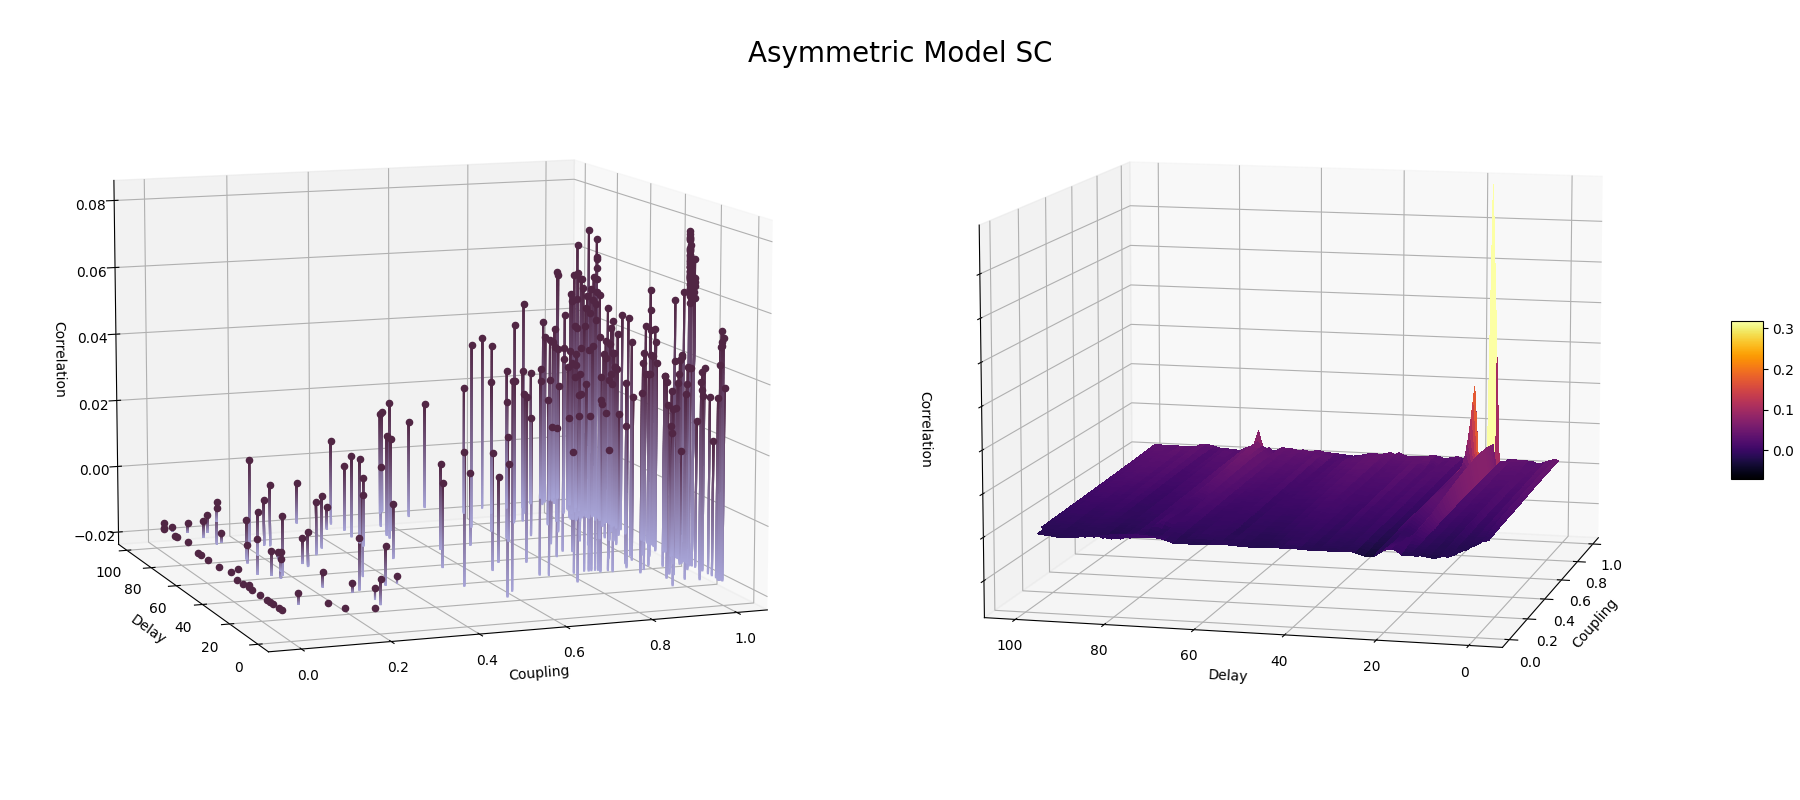

In [19]:
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

%matplotlib widget

def plot_meshgrid(df, title, xlabel, ylabel, zlabel):
    # Extracting data from dataframe
    coupling = df['(Coupling, Delay)'].apply(lambda x: x[0]).values
    delay = df['(Coupling, Delay)'].apply(lambda x: x[1]).values
    correlation = df['Correlation'].values

    print("Minimum correlation: {}".format(correlation.min()))
    print("Maximum correlation: {}".format(correlation.max()))

    # Create a structured grid
    num_points = 100
    xi = np.linspace(coupling.min(), coupling.max(), num_points)
    yi = np.linspace(delay.min(), delay.max(), num_points)
    xi, yi = np.meshgrid(xi, yi)

    # Interpolate over this grid
    zi = griddata((coupling, delay), correlation, (xi, yi), method='cubic')

    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8), subplot_kw=dict(projection='3d'), constrained_layout=True)

    gradient_stem(ax1, coupling, delay, correlation, correlation.min(), pinkish, purpleish)
    ax1.view_init(elev=10, azim=-110)

    surf = ax2.plot_surface(xi, yi, zi, linewidth=0, cmap='inferno', antialiased=False)
    fig.colorbar(surf, shrink=0.2, aspect=5)
    ax2.view_init(elev=10, azim=-166)
    ax2.zaxis.set_major_formatter(plt.NullFormatter())  # Hide the z-tick labels for ax2  
      
    # Set labels
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    ax1.set_zlabel(zlabel, labelpad=7)
    
    ax2.set_xlabel(xlabel)
    ax2.set_ylabel(ylabel)
    ax2.set_zlabel(zlabel)
    
    # Set the title
    fig.suptitle(title, y=0.95, fontsize=20)
    
    ax1.set_aspect('auto')
    ax2.set_aspect('auto')
        
    plt.show()

# Example usage
plot_meshgrid(model_asym_df, "Asymmetric Model SC", "Coupling", "Delay", "Correlation")


Minimum correlation: -0.03043348
Maximum correlation: 0.03760527


/tmp/ipykernel_3091001/3740401266.py:28: RuntimeWarning: invalid value encountered in scalar divide
  colors = [((zi - v) / (zi - bottom) * np.array(color_start) + (v - bottom) / (zi - bottom) * np.array(color_end)) for v in z_points]


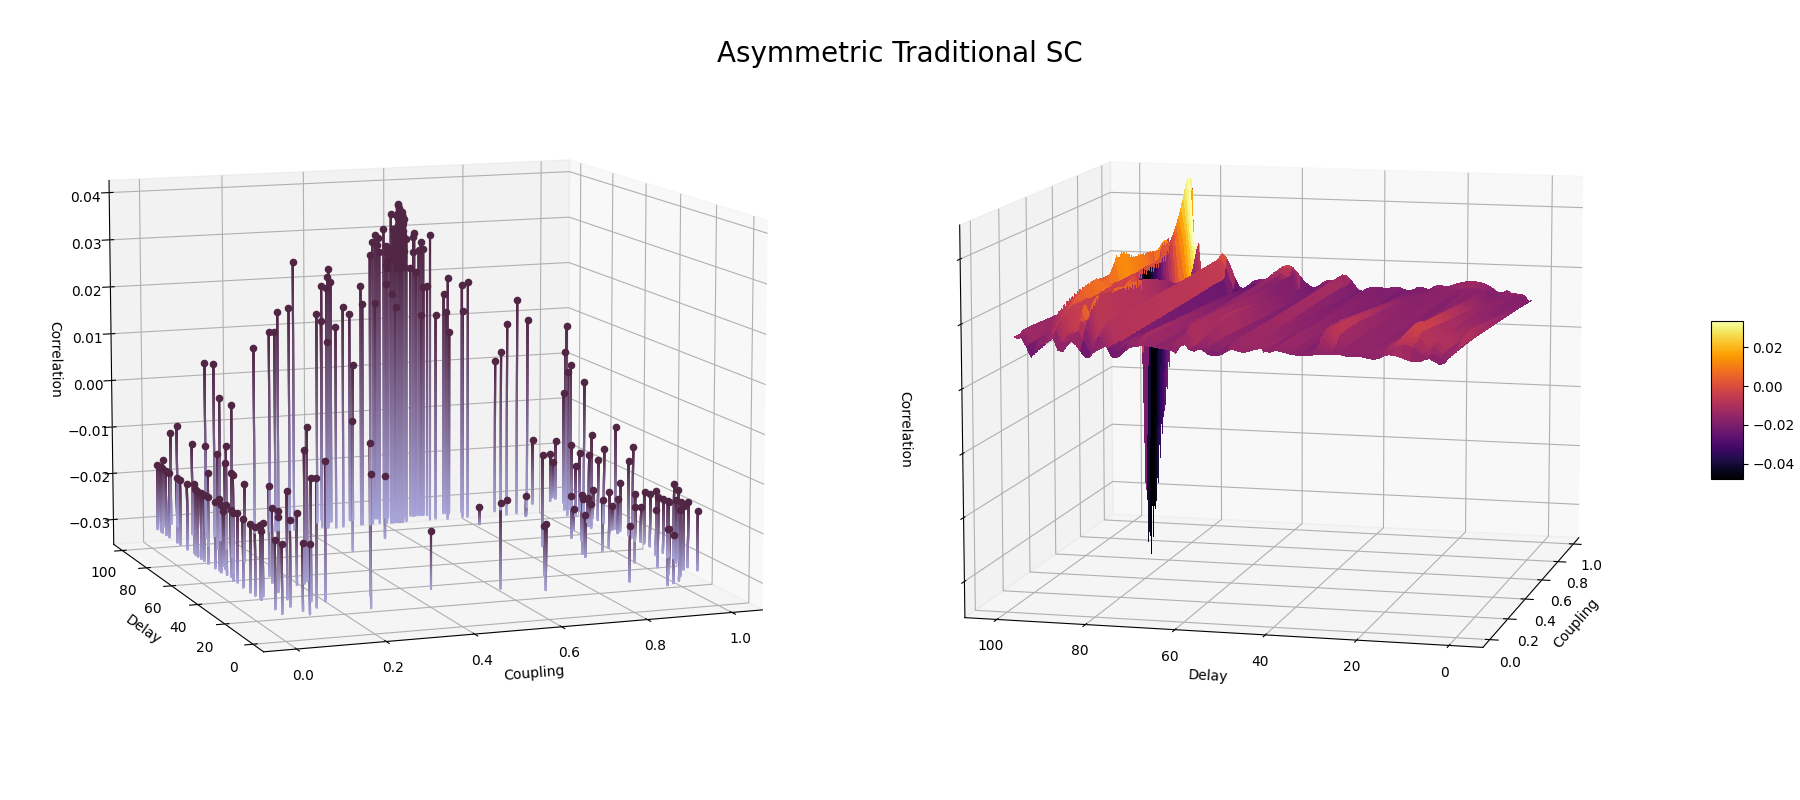

In [20]:
plot_meshgrid(trad_asym_df, "Asymmetric Traditional SC", "Coupling", "Delay", "Correlation")

Minimum correlation: -0.02032062
Maximum correlation: 0.08782831


/tmp/ipykernel_3091001/3740401266.py:28: RuntimeWarning: invalid value encountered in scalar divide
  colors = [((zi - v) / (zi - bottom) * np.array(color_start) + (v - bottom) / (zi - bottom) * np.array(color_end)) for v in z_points]


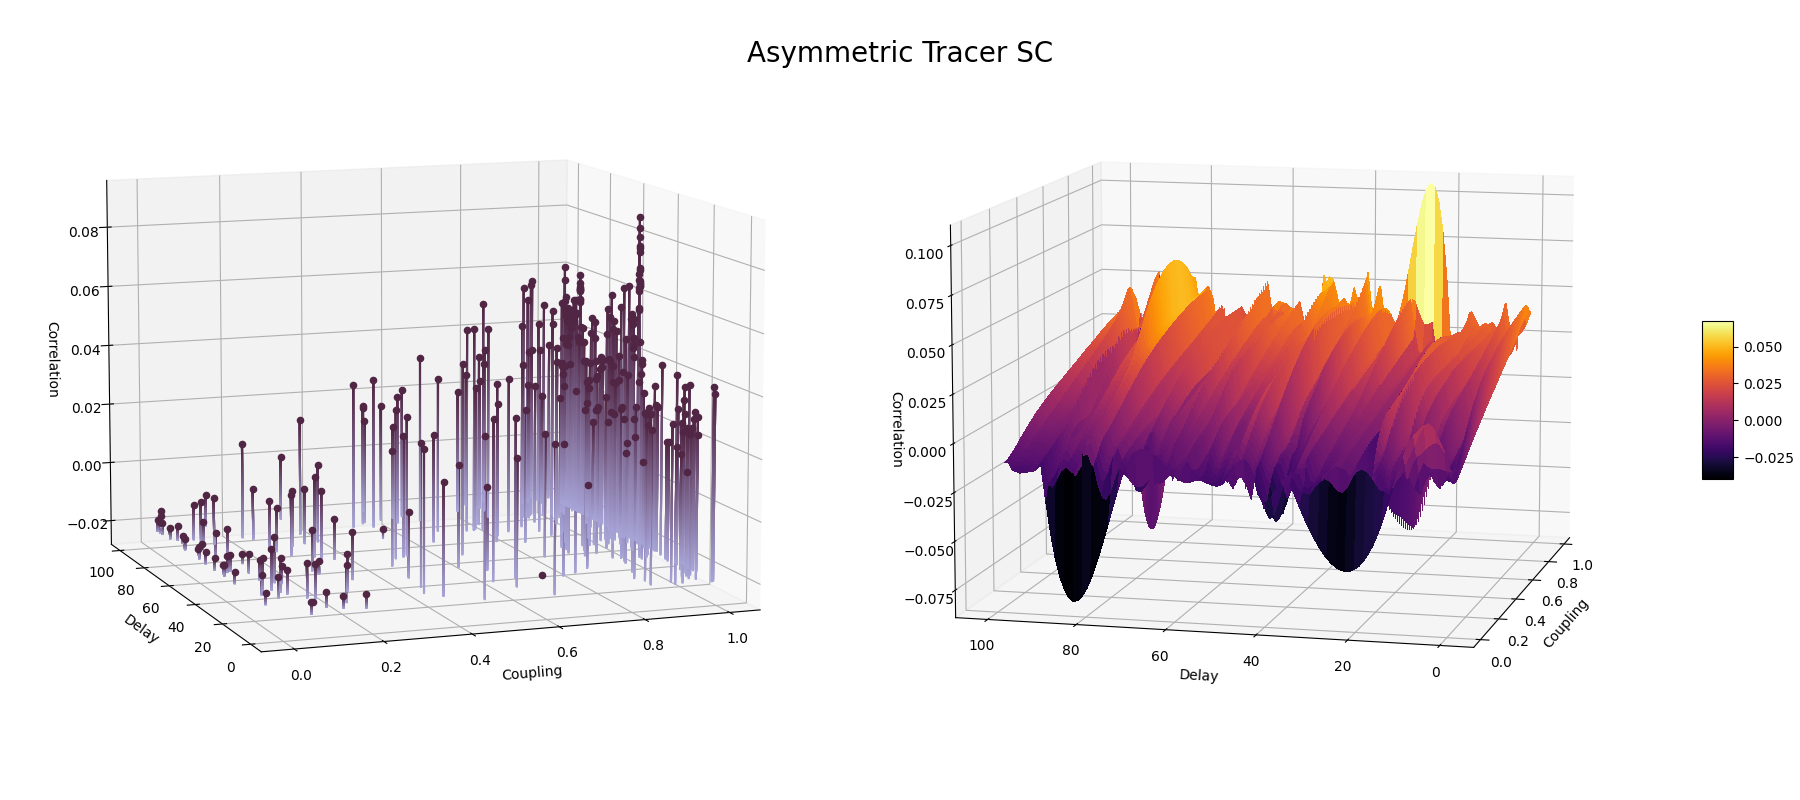

In [ ]:
plot_meshgrid(tracer_asym_df, "Asymmetric Tracer SC", "Coupling", "Delay", "Correlation")